In [1]:
import numpy as np
import subprocess

prefix = 'AcousticMonopole'
forwardFile = prefix+'.forward_run.txt'
adjointFile = prefix+'.adjoint_run.txt'

In [2]:
ic0File = prefix+'.ic.0.q'
icFile = prefix+'.ic.q'
subprocess.check_call('cp '+ic0File+' '+icFile, shell=True)
subprocess.check_call('./forward --output '+forwardFile, shell=True)
fQoI0 = open(forwardFile,'r')
QoI0 = float(fQoI0.read())
fQoI0.close()
print ("QoI0: ", QoI0)

QoI0:  0.005983793989376384


In [7]:
subprocess.check_call('./adjoint --output '+adjointFile, shell=True)
fGrad0 = open(adjointFile,'r')
Grad0 = float(fGrad0.read())
fGrad0.close()
print ("Grad0: ", Grad0)

Grad0:  1.349362300533714e-14


In [22]:
ic_grad_file = prefix + '-00000000.adjoint.q'
grad_norm_file = prefix + '.spatial_inner_product.txt'
subprocess.check_call('mpirun -n 2 ./spatial_inner_product '+ic_grad_file+' '+ic_grad_file, shell=True)
fQoI0 = open(grad_norm_file,'r')
Grad0 = float(fQoI0.read())
fQoI0.close()
print ("ic_grad0: ", Grad0)

ic_grad0:  4.564786420616838e-07


In [19]:
Nk = 20
# Ak = np.zeros((Nk,),dtype=np.double)
Ak = 10.0**(0.0-0.25*np.array(range(Nk)))
QoIk = np.zeros((Nk,),dtype=np.double)
Gradk = np.zeros((Nk,),dtype=np.double)
ek = np.zeros((Nk,),dtype=np.double)

forwardFile = prefix+'.forward_run.txt'

In [17]:
# solution zaxpy test
zfile = icFile
xfile = ic_grad_file
yfile = ic0File
subprocess.check_call('./qfile_zaxpy ' + zfile + " " + \
                      "{:.16E}".format(1.0e-3) + ' ' + \
                      xfile + ' ' + yfile, shell=True)

0

In [23]:
forwardFile1 = prefix+'.forward_run.1.txt'

fId = open(prefix+'.gradient_accuracy.txt','w')
for k in range(Nk):
    actuation_amount = Ak[k]
    command = 'mpirun -n 2 ./qfile_zaxpy '+zfile+' '+"{:.16E}".format(actuation_amount)+' '+xfile+' '+yfile
    subprocess.check_call(command, shell=True)
    subprocess.check_call('./forward --output '+forwardFile1, shell=True)
    fQoI1 = open(forwardFile1,'r')
    QoIk[k] = float(fQoI1.read())
    fQoI1.close()

    Gradk[k] = (QoIk[k]-QoI0)/Ak[k]
    ek[k] = abs( (Gradk[k]-Grad0)/Grad0 )
    fId.write("{:.16E}".format(actuation_amount)+'\t'
                +"{:.16E}".format(QoIk[k])+'\t'
                +"{:.16E}".format(Gradk[k])+'\t'
                +"{:.16E}".format(ek[k]))
    print ("{:.16E}".format(actuation_amount), "{:.16E}".format(QoIk[k]), "{:.16E}".format(Gradk[k]), "{:.16E}".format(ek[k]))

fId.close()

1.0000000000000000E+00 5.9842504838768171E-03 4.5649450043303008E-07 3.4740664480248774E-05
5.6234132519034907E-01 5.9840506911956644E-03 4.5648755974575424E-07 1.9535818872377592E-05
3.1622776601683794E-01 5.9839383421833991E-03 4.5648365680625355E-07 1.0985715666962814E-05
1.7782794100389229E-01 5.9838751645348836E-03 4.5648146203173343E-07 6.1776604418533452E-06
1.0000000000000001E-01 5.9838396373991694E-03 4.5648022785338416E-07 3.4739669159067344E-06
5.6234132519034911E-02 5.9838196591069804E-03 4.5647953380741136E-07 1.9535322036476516E-06
3.1622776601683791E-02 5.9838084245143631E-03 4.5647914352560187E-07 1.0985484792715750E-06
1.7782794100389229E-02 5.9838021068470996E-03 4.5647892393889561E-07 6.1750361532497954E-07
1.0000000000000000E-02 5.9837985541643908E-03 4.5647880067903324E-07 3.4748033052115716E-07
5.6234132519034910E-03 5.9837965563449280E-03 4.5647873079712595E-07 1.9439122436851450E-07
3.1622776601683794E-03 5.9837954328887553E-03 4.5647869238350109E-07 1.102391495

In [12]:
Grad0*5.0e-2/6.

5.241170657766875e-05

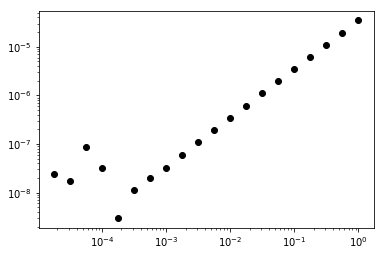

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1)
plt.loglog(Ak,ek,'ok')